# Building a Multi-Agent Restaurant System with AutoGen

Imagine ordering pizza by simply chatting with an AI assistant. No more scrolling through endless menus or navigating complex websites. With the power of multi-agent systems and Large Language Models (LLMs), this is becoming a reality. In this notebook, we will build restaurent ordering system step by step

## How it works ?

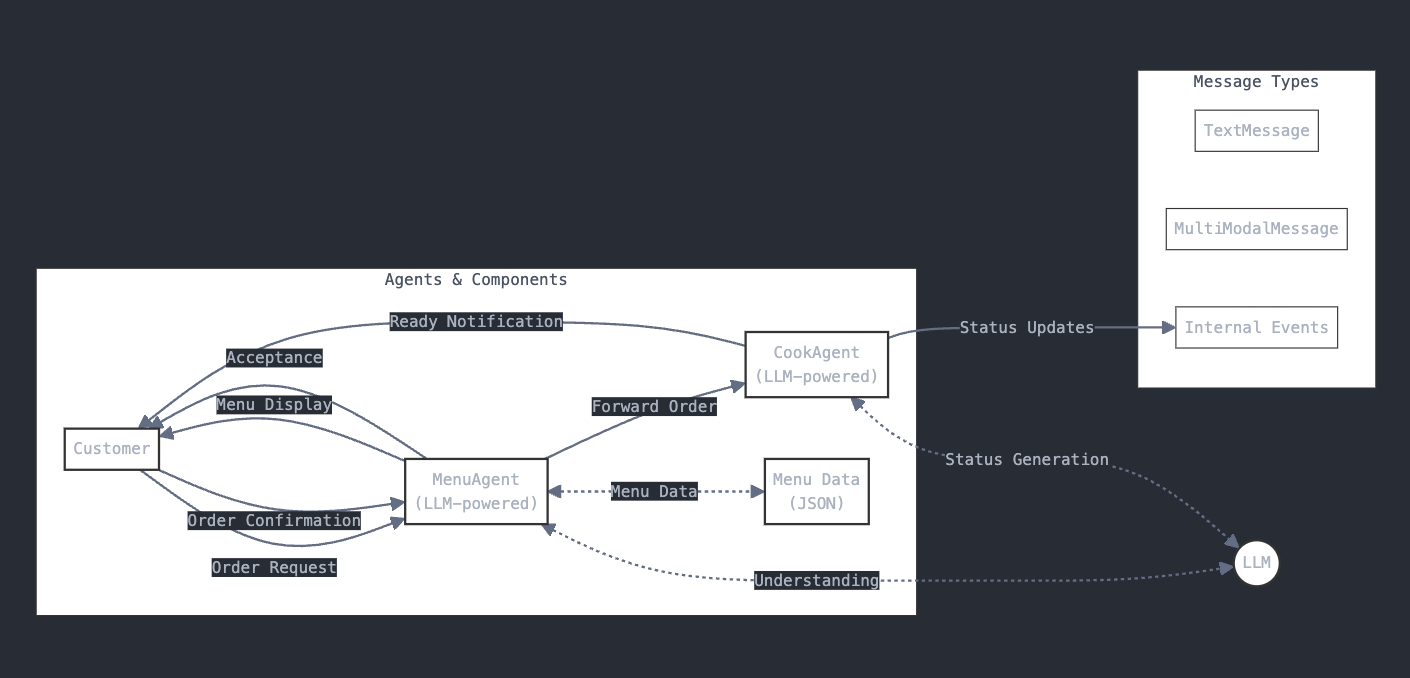

#### note : Please read my article for detail explanation here 

## Step 1 : Environment Setup

First, let's install required packages, set up environment and create a .env file to place the azure open ai credentials

# Step 2 : Base Configuration

In [1]:
import os
from dotenv import load_dotenv
from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.messages import TextMessage, MultiModalMessage
from autogen_ext.models.openai import OpenAIChatCompletionClient
from autogen_core import Image as AGImage
from PIL import Image
from io import BytesIO
import requests
import random
from typing import List
from IPython.display import display


# Load environment variables
load_dotenv()

# Create the OpenAI model client
model_client = OpenAIChatCompletionClient(
    model=os.getenv("AZURE_CHATGPT_MODEL"),
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    api_base=os.getenv("AZURE_OPENAI_ENDPOINT"),
    api_type="azure",
    api_version=os.getenv("AZURE_OPENAI_API_VERSION")
)

# Step 3: Menu Data Structure

In [2]:
# Menu Data with Image URLs
MENU_DATA = {
    "menu_items": {
        "margherita": {
            "id": "pizza_001",
            "name": "Margherita Pizza",
            "description": "Classic pizza with tomato sauce, mozzarella, and basil",
            "price": 12.99,
            "image_url": "https://images.unsplash.com/photo-1513104890138-7c749659a591"
        },
        "pepperoni": {
            "id": "pizza_002",
            "name": "Pepperoni Pizza",
            "description": "Traditional pizza topped with pepperoni slices",
            "price": 14.99,
            "image_url": "https://images.unsplash.com/photo-1601924582970-9238bcb495d9"
        }
    }
}

# Step 4: MenuAgent Implementation

In [3]:
# Define the MenuAgent class
class MenuAgent(AssistantAgent):
    def __init__(self, name: str):
        super().__init__(
            name=name,
            model_client=model_client,
            system_message="You are a helpful menu assistant who provides details about menu items and helps customers with their food orders."
        )
        self.menu_data = MENU_DATA

    def is_valid_item(self, item_name: str) -> bool:
        """Check if the item exists in the menu."""
        return item_name.lower() in self.menu_data["menu_items"]

    def get_available_items(self) -> str:
        """Return a comma-separated list of available menu items."""
        return ", ".join(self.menu_data["menu_items"].keys())

    async def get_menu_item(self, item_name: str) -> MultiModalMessage:
        """Fetch menu item details and return a formatted response."""
        if not self.is_valid_item(item_name):
            return TextMessage(
                content=f"Sorry, {item_name} is not available. Here's our menu: {self.get_available_items()}",
                source=self.name
            )
        
        item = self.menu_data["menu_items"][item_name.lower()]
        response = requests.get(item["image_url"])
        pil_image = Image.open(BytesIO(response.content))

        # Resize the image for consistency
        resized_image = pil_image.resize((200, int(200 * (pil_image.height / pil_image.width))))
        ag_image = AGImage(resized_image)

        # Description
        description = (
            f"Here's our {item['name']}:\n"
            f"{item['description']}\n"
            f"Price: ${item['price']}\n\n"
            f"Would you like to place an order for this {item['name']}? 🍕"
        )

        # Display image inline in Jupyter
        display(resized_image)

        return MultiModalMessage(
            content=[description, ag_image],
            source=self.name
        )

    async def confirm_order(self, item_name: str) -> TextMessage:
        """Send confirmation message with estimated preparation time."""
        cooking_time = random.randint(15, 25)
        return TextMessage(
            content=f"Thank you for confirming your order for {item_name.capitalize()}! "
                   f"Your order will be ready in approximately {cooking_time} minutes. "
                   f"Our chef will start preparing it right away.",
            source=self.name
        )

# Step 5: CookAgent Implementation

In [4]:
# Define the CookAgent class
class CookAgent(AssistantAgent):
    def __init__(self, name: str):
        super().__init__(
            name=name,
            model_client=model_client,
            system_message="You are a professional chef who provides updates about the cooking process and completes orders."
        )

    async def process_order(self, order: TextMessage) -> List[TextMessage]:
        """Simulate the cooking process and return status updates."""
        events = [
            ("ToolCallRequestEvent", "Order received and validated"),
            ("ToolCallExecutionEvent", "Starting preparation"),
            ("ToolCallExecutionEvent", "Cooking in progress"),
            ("ToolCallExecutionEvent", "Order completed")
        ]
        return [TextMessage(content=f"{event_type}: {status}", source=self.name) for event_type, status in events]

    async def send_completion_notice(self) -> TextMessage:
        """Notify the customer that the order is ready."""
        return TextMessage(
            content="🎉 Your order is ready! Please pick it up from the counter. Enjoy your meal! 🍕",
            source=self.name
        )

# Step 6: Running the System


=== Multi-Agent Restaurant Order System ===

📱 Customer: I would like to order margherita 



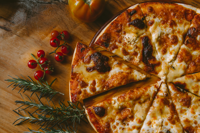

🍽️ MenuAgent: Here's our Margherita Pizza:
Classic pizza with tomato sauce, mozzarella, and basil
Price: $12.99

Would you like to place an order for this Margherita Pizza? 🍕 

📱 Customer: Yes, I confirm my order.

🍽️ MenuAgent: Thank you for confirming your order for Margherita! Your order will be ready in approximately 15 minutes. Our chef will start preparing it right away. 

👨‍🍳 Kitchen Updates:
ToolCallRequestEvent: Order received and validated
ToolCallExecutionEvent: Starting preparation
ToolCallExecutionEvent: Cooking in progress
ToolCallExecutionEvent: Order completed

👨‍🍳 CookAgent: 🎉 Your order is ready! Please pick it up from the counter. Enjoy your meal! 🍕


In [5]:
# Main Execution Flow
async def main():
    print("\n=== Multi-Agent Restaurant Order System ===\n")
    menu_agent = MenuAgent(name="menu_agent")
    cook_agent = CookAgent(name="cook_agent")

    # Step 1: Customer places an order
    order_item = "margherita"  # Change this to "margherita" or "pepperoni" for valid orders. 
                          # Use "chicken" or any invalid name to test error handling.

    customer_request = TextMessage(content=f"I would like to order {order_item}", source="customer")
    print("📱 Customer:", customer_request.content, "\n")

    # Step 2: MenuAgent responds
    menu_response = await menu_agent.get_menu_item(order_item)
    if isinstance(menu_response, TextMessage):
        print(f"🍽️ MenuAgent: {menu_response.content}")
        return
    print(f"🍽️ MenuAgent: {menu_response.content[0]}", "\n")

    # Step 3: Customer confirms the order
    confirmation_response = await menu_agent.confirm_order(order_item)
    print("📱 Customer: Yes, I confirm my order." "\n")
    print("🍽️ MenuAgent:", confirmation_response.content, "\n")

    # Step 4: CookAgent processes the order
    print("👨‍🍳 Kitchen Updates:")
    status_updates = await cook_agent.process_order(customer_request)
    for update in status_updates:
        print(update.content)
    print()

    # Step 5: Notify order completion
    completion_notice = await cook_agent.send_completion_notice()
    print("👨‍🍳 CookAgent:", completion_notice.content)

# Use this block if you are running the script in a Jupyter Notebook
if __name__ == "__main__":
    await main()

# Use this block if you are running the script in a terminal (standalone Python environment)
# Uncomment the following lines if you're running in the terminal:
# if __name__ == "__main__":
#     import asyncio
#     asyncio.run(main())


